# Radial Basis Function Neural Network

## Basics
Jede lineare PDE zweiter Ordnung lässt sich in der Form
$$
\sum_{ij}^n(A)_{ij}\frac{\partial^2 u(x)}{\partial x_i \partial x_j}+\sum_i^n b_i\frac{\partial u(x)}{\partial x_i}+cu(x)+d=f(x)
$$
ausdrücken. Anhand der Matrix $A$ können diese weiter klassifiziert werden: \
elliptisch, falls A positiv oder negativ definit ist, i.e. Defekt $d=0$ und Trägheitsindex $t=0$ \
hyperbolisch, falls $d=0$ und $t=1$ oder $t=n-1$ \
ultrahyperbolisch, falls $d=0$ und $1<t<n-1$ \
parabolisch, falls A ausgeartet ist, i.e. $d>0$. \
 \
Der Defekt $d$ und Trägheitsindex $t$ sind wie folgt für
$$
\text{diag}(A)=(\lambda_1, ..., \lambda_n)
$$
definiert: \
$t =$ Anzahl der $j\in \{1,...,n\}$ mit $\lambda_j < 0$ \
$d =$ Anzahl der $j\in \{1,...,n\}$ mit $\lambda_j = 0$

## Poisson Eq. Example ($u_5$ Larsson, Fornberg)
$$
\Delta u(x)=f(x) \quad \text{in} \ \Omega \\
$$
$$
u = g(x) \quad \text{on} \ \partial \Omega
$$
Wähle Beispiel $u_5$ als bekannte Lösung:
$$
u_5(x,y)=\sin{(\pi(x^2+y^2))}
$$
Entsprechend betrachten wir $\text{dim}=2$ und $\Omega$ die Einheitsscheibe. Und es gilt
$$
\Delta u_5(x,y)= -4\pi(\pi (x^2+y^2)\sin{(\pi (x^2+y^2))}-\cos{(\pi (x^2+y^2))})
$$

### Approximation mit Methode 1:
$$
s(x,\epsilon)=\sum_{j=1}^N\lambda_j\phi(||x-x_j||,\epsilon)
$$
Dabei wird für $\phi(r,\epsilon)$ die Multiquadric RBF gewählt:
$$
\phi(r,\epsilon)=\sqrt{1+(\epsilon r)^2}
$$
Dementsprechend gilt für $\Delta \phi$ mit $\Delta \phi = \frac{\partial^2 \phi}{\partial x^2}+\frac{\partial^2 \phi}{\partial y^2}$ in Polarkoordinaten:
$$
\Delta \phi (r,\epsilon)= \frac{\partial^2 \phi}{\partial r^2}+\frac{1}{r}\frac{\partial \phi}{\partial r}+\frac{1}{r^2}\frac{\partial^2 \phi}{\partial \theta^2}
$$
Wobei $\phi$ hier nur von $r$ abhängt, entsprechend also gilt:
$$
\Delta \phi (r,\epsilon)= \frac{\partial^2 \phi}{\partial r^2}+\frac{1}{r}\frac{\partial \phi}{\partial r}
$$
Und damit:
$$
\Delta \phi (r,\epsilon)= \frac{\epsilon^2((\epsilon r)^2+2)}{((\epsilon r)^2 + 1)^{\frac{3}{2}}}
$$
Definiere $\phi$ ($\texttt{phi}$) und $\Delta \phi$ ($\texttt{Lphi}$) in $\texttt{Python}$:

In [1]:
import numpy as np

def phi(r, e):
    return np.sqrt(1 + (e*r) ** 2)

def Lphi(r, e):
    return e ** 2 * ((e*r) ** 2 + 2) / ((e*r) ** 2 + 1) ** (3/2)

Definiere $u_5$ ($\texttt{u}$) und $\Delta u_5$ ($\texttt{Lu}$) in $\texttt{Python}$:

In [2]:
def u(x, y):
    return np.sin(np.pi * (x ** 2 + y ** 2))

def Lu(x,y):
    return -4 * np.pi * (np.pi * (x ** 2 + y ** 2) * np.sin(np.pi * (x ** 2 + y ** 2)) - np.cos(np.pi * (x ** 2 + y ** 2)))

Erzeuge Distribution der $50$ Nodes und Center-Points (entsprechend Methode 1 sind diese hier identisch) auf der Einheitsscheibe, wobei $30$ im Inneren ($\texttt{intd}$) sind und $20$ auf dem Rand ($\texttt{bdyd}$) liegen:

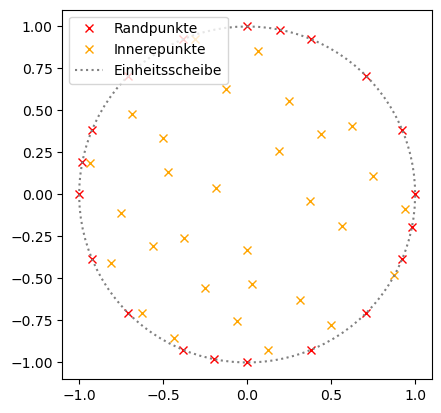

In [3]:
from scipy.stats import qmc
import matplotlib.pyplot as plt

rng_bdy = qmc.Halton(d=1, scramble = False) # Pseudo-Zufallsgenerator für eine Dimension (Winkel)
theta_bdy = rng_bdy.random(n = 20) * 2 * np.pi # Erzeuge 20 Zufallszahlen und skaliere von [0, 1] auf [0, 2 * Pi]

# Mit diesen Zufallszahlen erzeuge Punkte auf Einheitskreis
bdyd_x = np.sin(theta_bdy)
bdyd_y = np.cos(theta_bdy)

bdyd = np.array([bdyd_x, bdyd_y]).T.reshape(20,2)

# Pseudo-Zufallsgenerator für zwei Dimension (x, y)
rng_int = qmc.Halton(d=2, scramble = False)

intd = [] # Array das am Ende die 30 Innerenpunkt (x, y) enthalten soll

# Erzeuge "Monte-Carlo mäßig" 30 Punkte
while len(intd) < 30:
    intd_ = rng_int.random(n = 30 - len(intd)) * 2 - 1 # Erzeuge 30 - (Anzahl bereits erzeugter Werte) Zufallszahlen (x, y) auf [-1, 1]
    dist = np.linalg.norm(intd_, axis = 1) # Berechne Norm für diese Zufallszahlen (sqrt(x^2+y^2))
    ind = []
    for i, d in enumerate(dist): # Loop über alle erzeugten Zufallszahlen
        if d >= 1: # Wenn Norm der Zufallszahl >= 1 (i.e. Punkt liegt nicht in Einheitsscheibe), merke Index zum löschen
            ind.append(i)
    intd_ = np.delete(intd_, ind, axis = 0) # Lösche alle Punkte die außerhalb der Einheitsscheibe liegen aus Array
    if len(intd) == 0:
        intd = intd_
    else:
        intd = np.append(intd, intd_, axis = 0)

th = np.linspace(0, 2*np.pi, 100) # Äquidistante Winkeldistribution für das Ploten der Einheitsscheibe

#Plotten :)
plt.plot(bdyd_x, bdyd_y, color = 'red', linestyle = 'None', markersize = 5.5, marker = 'x', label = 'Randpunkte');
plt.plot(intd.T[0], intd.T[1], color = 'orange', linestyle = 'None', markersize = 5.5, marker = 'x', label = 'Innerepunkte')
plt.plot(np.sin(th), np.cos(th), color = 'gray', linestyle = 'dotted', label = 'Einheitsscheibe');
plt.gca().set_aspect('equal')
plt.legend(loc='upper left')
plt.show();

Erzeuge Punkte an denen der Error ($\texttt{errd}$) evaluiert wird:

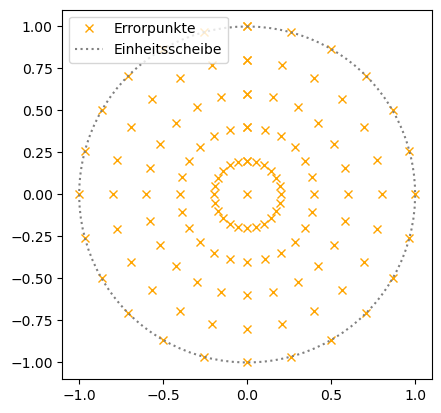

In [4]:
errd = np.array([[0, 0]])
theta = np.linspace(0, 2*np.pi, 25)
for i in range(5):
    x = np.sin(theta) * 1/5 * (i + 1)
    y = np.cos(theta) * 1/5 * (i + 1)
    d = [[x, y]]
    errd = np.append(errd, np.transpose(d).reshape((25, 2)), axis = 0)

th = np.linspace(0, 2*np.pi, 100) # Äquidistante Winkeldistribution für das Ploten der Einheitsscheibe

#Plotten :)
plt.plot(errd.T[0], errd.T[1], color = 'orange', linestyle = 'None', markersize = 5.5, marker = 'x', label = 'Errorpunkte')
plt.plot(np.sin(th), np.cos(th), color = 'gray', linestyle = 'dotted', label = 'Einheitsscheibe');
plt.gca().set_aspect('equal')
plt.legend(loc='upper left')
plt.show();

Der Error $E(\epsilon)$ ist definiert als
$$
E(\epsilon)=\text{max}_\Omega |s(x, \epsilon) - u(x)|
$$
Definiere in $\texttt{Python}$:

In [36]:
def E(s, u):
    return np.max(np.absolute(s - u))

Für das Problem
$$
\Delta u(x)=f(x) \quad \text{in} \ \Omega \\
$$
$$
u(x) = g(x) \quad \text{on} \ \partial \Omega
$$
Folgt mit $s(x,\epsilon)\approx u(x)$:
$$
\Delta s(x,\epsilon)=f(x) \quad \text{in} \ \Omega \\
$$
$$
s(x,\epsilon) = g(x) \quad \text{on} \ \partial \Omega
$$
Bzw. da in unserem Fall $f(x)$ und $g(x)$ aus einer vorgegebenen Lösung $u(x)$ definiert werden:
$$
\Delta s(x,\epsilon)=\Delta u(x) \quad \text{in} \ \Omega \\
$$
$$
s(x,\epsilon) = u(x) \quad \text{on} \ \partial \Omega
$$
Und entsprechend der Definition von $s(x, \epsilon)$:
$$
\sum_{j=1}^{N_I}\lambda_j\Delta \phi(||x-x_j||,\epsilon)=\Delta u(x) \quad \text{in} \ \Omega \\
$$
$$
\sum_{j=1}^{N_B}\lambda_j\phi(||x-x_j||,\epsilon) = u(x) \quad \text{on} \ \partial \Omega
$$
Mit
$$
(A)_{ij}=\Delta \phi(||x_i-x_j||,\epsilon) \quad \text{für} \ j < N_I,
$$
$$
(A)_{ij}=\phi(||x_i-x_j||,\epsilon) \quad \text{für} \ N_I < j < N_I + N_B,
$$
$$
\lambda = (\lambda_1,...,\lambda_{N_I},\lambda_{N_I+1},...,\lambda_{N_I+N_B})
$$
und
$$
\tilde{u}=(\Delta u(x_i), u(x_j)) \quad \text{für} \ i<N_I,j<N_B
$$
können wir das zusammenfassen zu:
$$
A\cdot \lambda = \tilde{u}
$$
Dieses Gleichungssystem lässt sich lösen, da $A$ nicht singulär wird und wird hier $\texttt{SciPy}$ überlassen:

In [16]:
from scipy import linalg
from scipy.spatial import distance_matrix

def meth1(e, int, bdy, err):
    dm = distance_matrix(err, np.append(int, bdy, axis = 0))
    dm_int = distance_matrix(int, np.append(int, bdy, axis = 0))
    dm_bdy = distance_matrix(bdy, np.append(int, bdy, axis = 0))

    u_tilde = np.append(Lu(int.T[0], int.T[1]), u(bdy.T[0], bdy.T[1]), axis = 0).reshape(50,1)
    A = np.asarray(np.bmat([[Lphi(dm_int, e)], [phi(dm_bdy, e)]]))
    lam = linalg.solve(A, u_tilde)

    return np.dot(phi(dm, e), lam)

Auswertung des Fehlers:

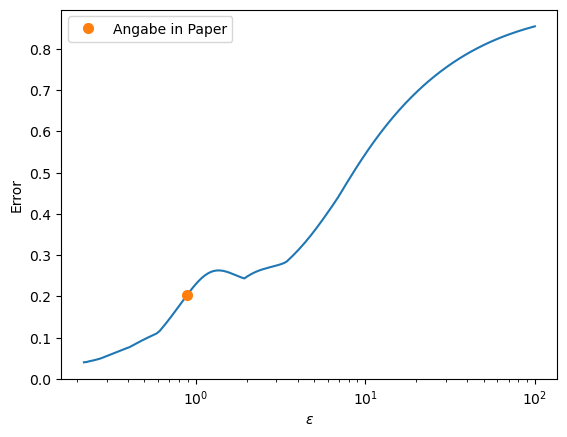

In [44]:
u_exact = u(errd.T[0], errd.T[1])
eps = np.geomspace(2.2e-1, 1e2, 150)
Es = []
for ep in eps:
    s_approx = meth1(ep, intd, bdyd, errd).flatten()
    Es.append(E(s_approx, u_exact))

plt.plot(eps, Es);
plt.plot([0.89], E(meth1(0.89, intd, bdyd, errd).flatten(), u_exact), linestyle = 'None', markersize = 7.0, marker = 'o', label = 'Angabe in Paper');
plt.xlabel('$\epsilon$');
plt.ylabel('Error')
plt.xscale('log');
plt.legend();
plt.show();

Für kleinere $\epsilon$ explodiert der Fehler und $\texttt{SciPy}$ wirft Errors, da $A$ nicht mehr well-posed ist.